In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *

In [2]:
from scipy.stats import norm
def discrete_normal(mu, sigma, discretization):
    d = norm(0, sigma)
    vals = np.linspace(-2*sigma, 2*sigma, discretization)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    return Categorical(vals, probs)

def make_env(depth, cost, discretization=False, ground_truth=False):
    """Returns a MouselabEnv with branching factor 2 and given depth and cost.
    
    If `ground_truth` is True, the reward observed at a given node will be
    constant across runs on this env. This reduces variance of the return."""
    sigma = 1
    reward = (discrete_normal(0, sigma, discretization)
              if discretization else Normal(0, sigma))
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth, cost, discretization=None, ground_truth=None, n=100):
    # Note, ground_truth can be an int in which case it acts as a random seed.
    if ground_truth is not None:
        np.random.seed(ground_truth)
        return [make_env(depth, cost, discretization, True) for _ in range(n)]
    else:
        return [make_env(depth, cost, discretization, False)] * n

In [25]:
%load_ext line_profiler

In [3]:
pol = LiederPolicy([1, 1, 1, 1, 1])
env = make_env(3, .1)
agent = Agent()
agent.register(env)
agent.register(pol)
# agent.run_episode()
# %prun agent.run_episode()

In [21]:
# %load_ext autoreload
# %autoreload 2
from distributions import *
d = Normal(0, 1)
d1 = Normal(0, 1)
x = dmax([d, d1])
print('E[x]', x.expectation())
y = dmax([x, x])
print('-----')
print('E[y]',  y.expectation())

sample dmax(Norm(0.00, 1.00), Norm(0.00, 1.00))
sample Norm(0.00, 1.00)
sample Norm(0.00, 1.00)
E[x] 0.559030185959
-----
sample dmax(dmax(Norm(0.00, 1.00), Norm(0.00, 1.00)), dmax(Norm(0.00, 1.00), Norm(0.00, 1.00)))
E[y] 0.559030185959


In [4]:
from evaluation import evaluate
envs = make_envs(3, .1, n=30)
evaluate(pol, envs)
%prun evaluate(pol, envs)

[ 5.939  0.715  0.603  0.545  1.   ] -> 1.154 in 1 sec
[ 4.813  0.646  0.438  0.892  1.   ] -> 1.138 in 1 sec
[ 9.673  0.383  0.792  0.529  1.   ] -> 1.044 in 1 sec
[ 6.112  0.926  0.071  0.087  1.   ] -> 0.687 in 1 sec
[ 1.182  0.833  0.778  0.87   1.   ] -> 1.103 in 2 sec
[ 9.808  0.799  0.461  0.781  1.   ] -> 1.053 in 1 sec
[ 2.064  0.64   0.143  0.945  1.   ] -> 1.129 in 2 sec
[ 5.697  0.415  0.265  0.774  1.   ] -> 1.13 in 1 sec
[ 5.105  0.568  0.019  0.618  1.   ] -> 1.098 in 2 sec
[ 6.509  0.617  0.944  0.682  1.   ] -> 1.141 in 2 sec
[ 10.   0.   1.   1.   1.] -> 1.147 in 2 sec
[ 1.  0.  0.  1.  1.] -> 0.916 in 2 sec
[ 5.578  0.759  1.     0.558  1.   ] -> 1.171 in 2 sec
[ 10.      0.412   1.      1.      1.   ] -> 1.154 in 1 sec
[ 1.    1.    1.    0.51  1.  ] -> 1.098 in 2 sec
[ 1.  0.  1.  0.  1.] -> 1.123 in 2 sec
[ 10.      0.206   1.      0.866   1.   ] -> 1.14 in 1 sec
[ 10.   0.   1.   0.   1.] -> 0.691 in 1 sec
[ 5.829  0.938  1.     0.551  1.   ] -> 1.178 in 2 sec
[ 

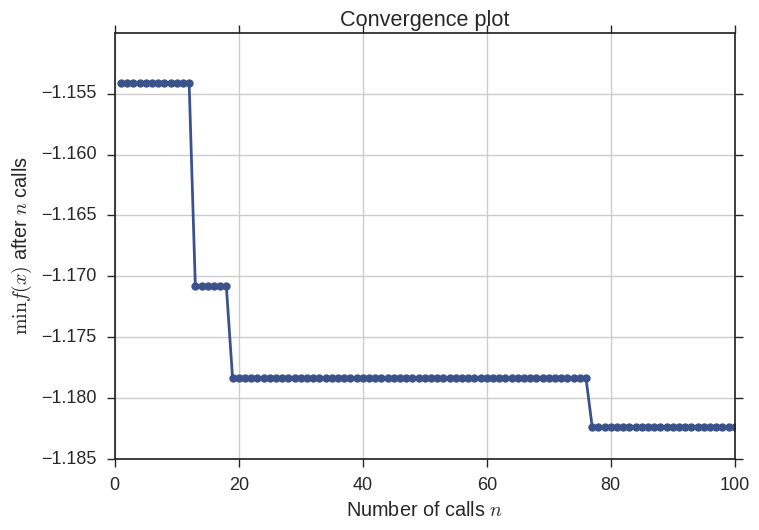

In [24]:
train_envs = make_envs(3, .1, 4, ground_truth=True, n=200)
pol, result = bo_policy(train_envs, max_cost=10, normalize_voi=False,
                        n_calls=100, verbose=1, n_jobs=40, return_result=True)

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [26]:
def run_params(depth=3, cost=.1):
    print('train', cost)
    train_envs = make_envs(depth, cost, discretization=4, n=200, ground_truth=True)
    env = train_envs[0]
    term_action = env.term_action
    policies = {
        # 'BO': bo_policy(train_envs, max_cost=len(env.tree), n_calls=30, n_jobs=40),
        # 'BO_unnorm': bo_policy(train_envs, normalize_voi=False, 
        #                        max_cost=100, n_calls=30, n_jobs=40),
        'BO': pol,
        'myopic': LiederPolicy([1, 1, 0, 0, 1]),
        # 'optimal': optimal_policy(env),
        'full': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    test_envs = make_envs(depth, cost, n=500, ground_truth=True)
    def test():
        print('test', cost)
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['depth'] = depth
            df['cost'] = cost
            yield df
    return pd.concat(test())

df = run_params(cost=.1)

train 0.1
test 0.1


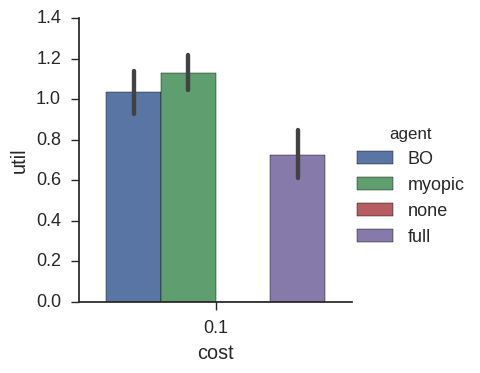

In [28]:
sns.set_style('ticks')
sns.factorplot('cost', 'util', hue='agent', data=df, kind='bar')
# plt.ylim(-2, 2)

(-2, 2)

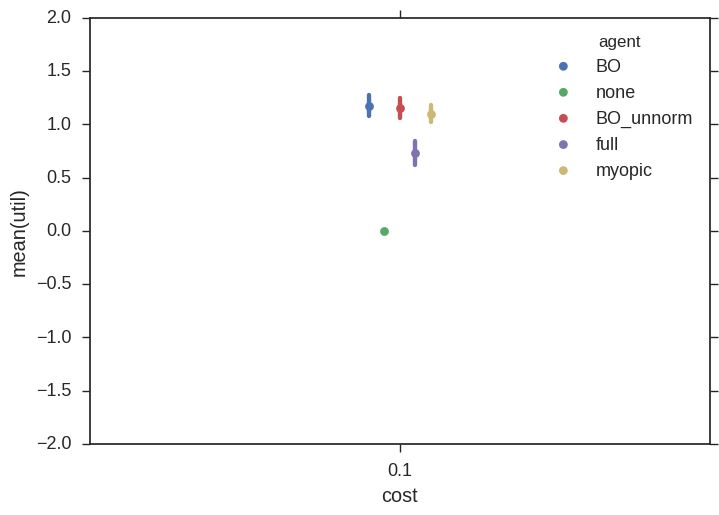

In [5]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df, markers='.', size=(4,4), 
              dodge=.1)
plt.ylim(-2, 2)

In [ ]:
# sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

In [86]:
empirical = df.query('agent == "BO"').util
# print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

empirical ~ $N(14.9, 14.9^2)$


In [26]:
empirical = df.query('agent == "BO"').util
print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

BO = 14.1
empirical ~ $N(12.0, 11.9^2)$


12.425000000000001

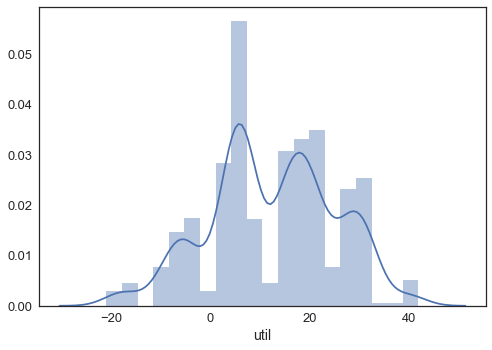

In [62]:
sns.distplot(df.query('agent == "BO"').util)
df.query('agent == "BO"').util.mean()

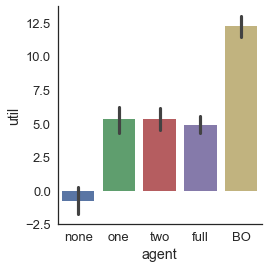

In [12]:
sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')